In [43]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns

import torch

from src.utils import haversine, radians
from dataset import ObservationsDataset

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
legend_df = pd.read_csv('data/subway_locations_connections.csv')

def parse_string_array_frame(df, column):
    df[column] = df[column].apply(lambda x : [str(i.strip().upper()[1:-1]) for i in x[1:-1].split(',')])

def parse_float_array_frame(df, column):
    df[column] = df[column].apply(lambda x : [float(i.strip()) for i in x[1:-1].split(',')])

parse_string_array_frame(legend_df, 'dest_name')
parse_string_array_frame(legend_df, 'dest_id')
parse_float_array_frame(legend_df, 'dest_lat')
parse_float_array_frame(legend_df, 'dest_long')

origin_cols = [x for x in legend_df.columns if x.startswith('origin')]
dest_cols = [x for x in legend_df.columns if x.startswith('dest')]

legend_df[['origin_lat', 'origin_long', 'dest_lat', 'dest_long']] = \
    legend_df[['origin_lat', 'origin_long', 'dest_lat', 'dest_long']].applymap(lambda x : radians(x))

In [45]:
nodes_df = legend_df[origin_cols]
# nodes_df = nodes_df.rename(columns={'origin_lat': 'lat', 'origin_long': 'lon'})
nodes_set = set(nodes_df['origin_name'].unique())

edges = []
for i, row in legend_df.iterrows():
    for name, id, lat, lon in zip(*(row[col] for col in dest_cols)):
        if name not in nodes_set:
            nodes_df = nodes_df.append(pd.DataFrame([[name, id, lat, lon]], columns=origin_cols), ignore_index=True)
            nodes_set.add(name)

        olon, olat = row['origin_long'], row['origin_lat']
        dist = float(haversine(olon, olat, lon, lat))

        if dist < 1e-8:
            continue

        edges.append((row['origin_name'], name, {'dist' : dist}))

edges[:5]
        

[('1 AV', '3 AV', {'dist': 0.4333996170612458}),
 ('1 AV', 'BEDFORD AV', {'dist': 2.579846524429354}),
 ('103 ST', '96 ST', {'dist': 0.6985162154962519}),
 ('103 ST', 'CATHEDRAL PKWY', {'dist': 0.5189875230607629}),
 ('103 ST - CORONA PLAZA', 'JUNCTION BLVD', {'dist': 0.5806388684783266})]

In [46]:
nodes_df = nodes_df.rename(columns=lambda x : x[len('origin_'):] if x.startswith('origin_') else x)
nodes_df = nodes_df.rename(columns={'long':'lon'})
nodes_df['id'] = nodes_df['name']
nodes_df = nodes_df.set_index('name')
nodes_df

,id,lat,lon
name,,,
1 AV,1 AV,0.710889,-1.291223
103 ST,103 ST,0.712085,-1.290992
103 ST - CORONA PLAZA,103 ST - CORONA PLAZA,0.711219,-1.289147
104 ST,104 ST,0.710030,-1.288711
110 ST,110 ST,0.712007,-1.290571
...,...,...,...
WOODSIDE - 61 ST,WOODSIDE - 61 ST,0.711145,-1.289850
WORLD TRADE CENTER,WORLD TRADE CENTER,0.710569,-1.291714
YORK ST,YORK ST,0.710373,-1.291312


In [47]:
emp = pd.read_csv('data/mta_employment.csv').set_index('origin_name')
emp = emp[emp.columns[-1]].rename('labor_force_rate')
emp = emp.replace('-', None).astype(float) / 100.0
nodes_df = nodes_df.join(emp)
nodes_df.head(5)

,id,lat,lon,labor_force_rate
name,,,,
1 AV,1 AV,0.710889,-1.291223,0.734
103 ST,103 ST,0.712085,-1.290992,0.641
103 ST - CORONA PLAZA,103 ST - CORONA PLAZA,0.711219,-1.289147,0.718
104 ST,104 ST,0.710030,-1.288711,0.622
110 ST,110 ST,0.712007,-1.290571,0.619


In [48]:
house_pricing = pd.read_csv('data/mta_housing_salePrice.csv').set_index('origin_name')
house_pricing.drop(columns=[x for x in house_pricing.columns if not x.startswith('Estimate')], inplace=True)
house_pricing.rename(columns= lambda x: 'housing_sales_num_' + x[len('estimate!!'):], inplace=True)
nodes_df = nodes_df.join(house_pricing)
nodes_df.head(5)

,id,lat,lon,labor_force_rate,housing_sales_num_Total:,"housing_sales_num_Total:!!Less than $10,000","housing_sales_num_Total:!!$10,000 to $14,999","housing_sales_num_Total:!!$15,000 to $19,999","housing_sales_num_Total:!!$20,000 to $24,999","housing_sales_num_Total:!!$25,000 to $29,999",...,"housing_sales_num_Total:!!$175,000 to $199,999","housing_sales_num_Total:!!$200,000 to $249,999","housing_sales_num_Total:!!$250,000 to $299,999","housing_sales_num_Total:!!$300,000 to $399,999","housing_sales_num_Total:!!$400,000 to $499,999","housing_sales_num_Total:!!$500,000 to $749,999","housing_sales_num_Total:!!$750,000 to $999,999","housing_sales_num_Total:!!$1,000,000 to $1,499,999","housing_sales_num_Total:!!$1,500,000 to $1,999,999","housing_sales_num_Total:!!$2,000,000 or more"
name,,,,,,,,,,,,,,,,,,,,,
1 AV,1 AV,0.710889,-1.291223,0.734,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103 ST,103 ST,0.712085,-1.290992,0.641,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103 ST - CORONA PLAZA,103 ST - CORONA PLAZA,0.711219,-1.289147,0.718,33.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,9.0,0.0,9.0,15.0,0.0,0.0,0.0
104 ST,104 ST,0.710030,-1.288711,0.622,26.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0
110 ST,110 ST,0.712007,-1.290571,0.619,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
emp = pd.read_csv('data/mta_median_income.csv').set_index('origin_name')
median_income = emp['Estimate!!Median income (dollars)!!FAMILIES!!Families'].rename('median_income')
median_income[median_income == 0] = median_income[median_income != 0].mean()
nodes_df = nodes_df.join(median_income)
nodes_df.head(5)

,id,lat,lon,labor_force_rate,housing_sales_num_Total:,"housing_sales_num_Total:!!Less than $10,000","housing_sales_num_Total:!!$10,000 to $14,999","housing_sales_num_Total:!!$15,000 to $19,999","housing_sales_num_Total:!!$20,000 to $24,999","housing_sales_num_Total:!!$25,000 to $29,999",...,"housing_sales_num_Total:!!$200,000 to $249,999","housing_sales_num_Total:!!$250,000 to $299,999","housing_sales_num_Total:!!$300,000 to $399,999","housing_sales_num_Total:!!$400,000 to $499,999","housing_sales_num_Total:!!$500,000 to $749,999","housing_sales_num_Total:!!$750,000 to $999,999","housing_sales_num_Total:!!$1,000,000 to $1,499,999","housing_sales_num_Total:!!$1,500,000 to $1,999,999","housing_sales_num_Total:!!$2,000,000 or more",median_income
name,,,,,,,,,,,,,,,,,,,,,
1 AV,1 AV,0.710889,-1.291223,0.734,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83750.0
103 ST,103 ST,0.712085,-1.290992,0.641,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,195250.0
103 ST - CORONA PLAZA,103 ST - CORONA PLAZA,0.711219,-1.289147,0.718,33.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9.0,0.0,9.0,15.0,0.0,0.0,0.0,42328.0
104 ST,104 ST,0.710030,-1.288711,0.622,26.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,69375.0
110 ST,110 ST,0.712007,-1.290571,0.619,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33323.0


In [50]:
house_pricing = pd.read_csv('data/mta_population.csv').set_index('origin_name')
house_pricing.drop(columns=[x for x in house_pricing.columns if not x.startswith('Estimate')], inplace=True)
house_pricing.rename(columns= lambda x: x[len('estimate!!population!!'):], inplace=True)
nodes_df = nodes_df.join(house_pricing)
nodes_df.head(5)

,id,lat,lon,labor_force_rate,housing_sales_num_Total:,"housing_sales_num_Total:!!Less than $10,000","housing_sales_num_Total:!!$10,000 to $14,999","housing_sales_num_Total:!!$15,000 to $19,999","housing_sales_num_Total:!!$20,000 to $24,999","housing_sales_num_Total:!!$25,000 to $29,999",...,population!!AGE!!40 to 44 years,population!!AGE!!45 to 49 years,population!!AGE!!50 to 54 years,population!!AGE!!55 to 59 years,population!!AGE!!60 to 64 years,population!!AGE!!65 to 69 years,population!!AGE!!70 to 74 years,population!!AGE!!75 to 79 years,population!!AGE!!80 to 84 years,population!!AGE!!85 years and over
name,,,,,,,,,,,,,,,,,,,,,
1 AV,1 AV,0.710889,-1.291223,0.734,0.0,0.0,0.0,0.0,0.0,0.0,...,457.0,155.0,61.0,642.0,259.0,250.0,141.0,90.0,49.0,25.0
103 ST,103 ST,0.712085,-1.290992,0.641,0.0,0.0,0.0,0.0,0.0,0.0,...,940.0,674.0,563.0,662.0,818.0,805.0,571.0,225.0,262.0,175.0
103 ST - CORONA PLAZA,103 ST - CORONA PLAZA,0.711219,-1.289147,0.718,33.0,0.0,0.0,0.0,0.0,0.0,...,356.0,278.0,240.0,84.0,103.0,116.0,41.0,29.0,42.0,22.0
104 ST,104 ST,0.710030,-1.288711,0.622,26.0,0.0,0.0,0.0,0.0,0.0,...,169.0,227.0,188.0,184.0,151.0,155.0,106.0,25.0,11.0,33.0
110 ST,110 ST,0.712007,-1.290571,0.619,0.0,0.0,0.0,0.0,0.0,0.0,...,377.0,233.0,312.0,149.0,226.0,183.0,82.0,300.0,15.0,87.0


In [51]:
nodes_df.dropna(inplace=True)
nodes_set = set(nodes_df.index.unique())

In [52]:
def make_graph_from_df(nodes_df, edges, name='TLC', directed=True):
    G = nx.Graph(directed=directed)
    G.graph['Name'] = name

    G.add_nodes_from(nodes_df.to_dict('index').items())
    G.add_edges_from(edges)
    G.remove_edges_from(nx.selfloop_edges(G))

    return G

In [53]:
G = make_graph_from_df(nodes_df, edges)
G.number_of_nodes(), G.number_of_edges()

(373, 486)

In [54]:
nodes_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 373 entries, 1 AV to ZEREGA AV
Data columns (total 51 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   id                                                  373 non-null    object 
 1   lat                                                 373 non-null    float64
 2   lon                                                 373 non-null    float64
 3   labor_force_rate                                    373 non-null    float64
 4   housing_sales_num_Total:                            373 non-null    float64
 5   housing_sales_num_Total:!!Less than $10,000         373 non-null    float64
 6   housing_sales_num_Total:!!$10,000 to $14,999        373 non-null    float64
 7   housing_sales_num_Total:!!$15,000 to $19,999        373 non-null    float64
 8   housing_sales_num_Total:!!$20,000 to $24,999        373 non-null    float64


In [55]:
nx.readwrite.write_gpickle(G, 'data/network.gpickle')

In [56]:
mta = pd.read_csv('data/subway_2021_ridership.csv')
mta = mta[mta['flag'] == True]
mta['DATE_time'] = pd.to_datetime(mta['DATE_time'])
mta['DATE'] = mta['DATE_time'].dt.date
mta = mta.groupby(['DATE', 'STATION'], as_index=False)['ridership'].sum()
mta = mta[mta['STATION'].isin(nodes_set)]
mta['ridership'] = mta['ridership'].astype('float32')
mta

,DATE,STATION,ridership
0,2020-12-26,1 AV,191.0
1,2020-12-26,103 ST,317.0
3,2020-12-26,104 ST,20.0
4,2020-12-26,110 ST,239.0
5,2020-12-26,111 ST,70.0
...,...,...,...
102330,2021-12-24,WINTHROP ST,390.0
102331,2021-12-24,WOODHAVEN BLVD,1546.0
102332,2021-12-24,WOODLAWN,488.0
102334,2021-12-24,YORK ST,989.0


In [57]:
from sklearn.preprocessing import MinMaxScaler
mean_mta = mta.groupby('STATION', as_index=False)['ridership'].mean()
torch.save(ObservationsDataset(mean_mta), f'datasets/mean.dat')

In [58]:
mean_mta['ridership'] = MinMaxScaler().fit_transform(mean_mta['ridership'].values.reshape(-1, 1)).reshape(-1)

<AxesSubplot:xlabel='STATION', ylabel='ridership'>

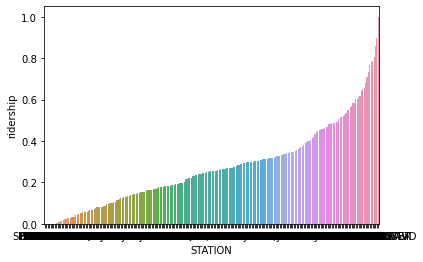

In [59]:
sns.barplot(x='STATION', y='ridership', data=mean_mta.sort_values('ridership'))

<AxesSubplot:xlabel='ridership', ylabel='Density'>

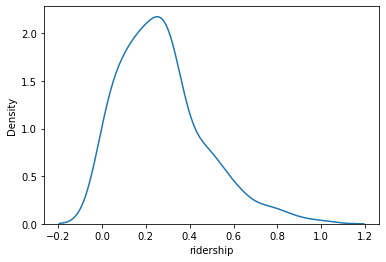

In [60]:
sns.kdeplot(data=mean_mta, x="ridership")

In [61]:
for day in mta['DATE'].unique()[:30]:
    ds = ObservationsDataset.from_dataframe_by_day(mta, day)
    torch.save(ds, f'datasets/{day}.dat')